## Import all packages

In [1]:
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip, datetime
from datetime import datetime

'''Data Viz'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl
import random

%matplotlib inline

'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss
from sklearn.metrics import explained_variance_score, mean_absolute_error
from sklearn.metrics import roc_curve, auc, roc_auc_score, mean_squared_error
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression

'''Algos'''
from tslearn.clustering import KShape, TimeSeriesScalerMeanVariance, TimeSeriesKMeans
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier

'''TensorFlow and Keras'''
import tensorflow as tf
import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization, Input, Lambda
from tensorflow.keras.layers import Embedding, Flatten, dot
from tensorflow.keras import regularizers
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.models import load_model

'''Dataset analysis'''
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from itertools import chain
from statistics import stdev
from math import sqrt

Using TensorFlow backend.


## define input parameters


There are four electrodes in the trackingpad of ETEE. Training data are measured in the anti-clockwise sequence. 

In [2]:
# K.tensorflow_backend._get_available_gpus()
pair = [8,9,11,12]
anticlock_sequence = [3,2,1,0]
clockwise_sequence = [0,1,2,3]
resolution = 10

## Import traing datasets and analyse

C:\Users\TG0\PycharmProjects
D:\signal_etee_trackpad


(0, 1000)

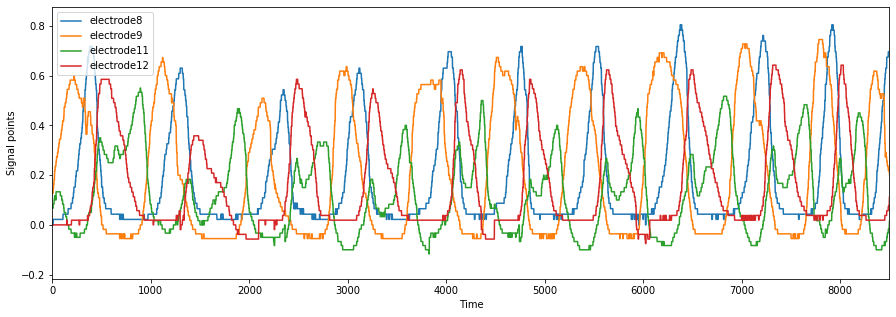

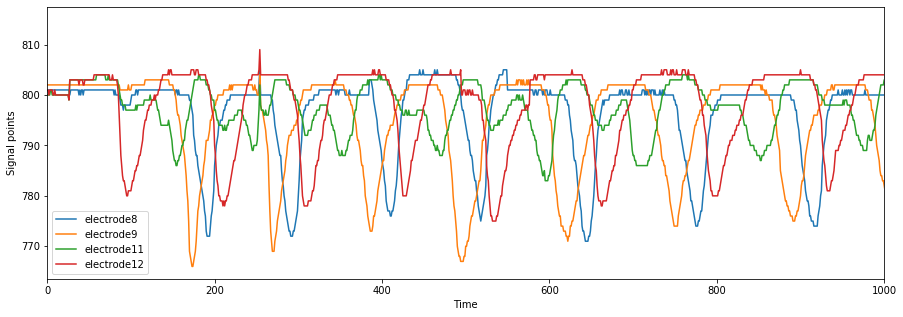

In [3]:
print(os.getcwd())
os.chdir('D:\\signal_etee_trackpad')
print(os.getcwd())
# def gaus(x,a,x0,sigma):
#     return a*np.exp(-(x-x0)**2/(2*sigma**2))
def get_electrode_data(filename):
    electrodes_points = pd.read_csv(filename)
    electrodes_points.columns = electrodes_points.columns.astype(float)
    electrodes_points.columns = electrodes_points.columns.astype(int)
    return electrodes_points.loc[:,pair]

def plot_electrode_data(electrodes_points):
    plt.figure(figsize= (15,5))
    for electrode in electrodes_points.columns:
        plt.plot(electrodes_points.index,electrodes_points.loc[:,electrode],label='electrode' + str(electrode))
    plt.xlabel('Time')
    plt.ylabel('Signal points')
    plt.legend()
    
plot_electrode_data(get_electrode_data('circle6.csv'))
plt.xlim([0,8500])
plot_electrode_data(get_electrode_data('circle.csv'))
# plot_electrode_data(get_electrode_data('y_axis.csv'))
plt.xlim([0,1000])

## Signal behaviour analysis

### circle signal

The circle signal can be separated with every 90 degree based on the peak of each electrode.
Electrode 11 (left side on the left hand) has a up shifted baseline plus very low signal. It's going to be our main concern.
* peak height is defined as below 795;
* peak distance is defined as 80
* pick signal in the first 8000 time steps due to the shifted baseline of electrode 11 after 8000 time steps.

In [4]:
print(os.getcwd())
os.chdir('D:\\signal_etee_trackpad')
print(os.getcwd())
def find_peak(data,height=0.2,distance=350):
    peaks={}
    for electrode in data.columns:
        peaks[electrode] = find_peaks(data.loc[:,electrode],height = height, distance= distance)[0]
        value = data.loc[:,electrode].to_numpy()
        for i,index in enumerate(peaks[electrode]):
            try: 
                segment = value[int(index-distance/4):int(index+distance/4)]
                popt,pcov = curve_fit(gaus,np.linspace(int(index-distance/4),int(index+distance/4-1),
                                                       int(index+distance/4-1) - int(index-distance/4) + 1),
                                      segment,p0=[value[index],index,distance/4])
                peaks[electrode][i] = int(popt[1])
            except:
                continue
#     peak_index1 = find_peaks(1000 - data.loc[:,pair[1]],height = height, distance= distance)
#     peak_index2 = find_peaks(1000 - data.loc[:,pair[2]],height = height, distance= distance)
#     peak_index3 = find_peaks(1000 - data.loc[:,pair[3]],height = height, distance= distance)
        print('number of peaks in electrode ', electrode, ' = ',len(peaks[electrode]))
    return peaks
def plot_peaks(data,peaks):
    for electrode in data.columns:
        plt.plot(data.index[peaks[electrode]],data.loc[peaks[electrode],electrode],'x')
        

def electrode_sequence(sequence):
    elec_sequence=[]
    for i in sequence:
        elec_sequence.append(pair[i])
    return elec_sequence

def rotate(l,n):
    return l[n:] + l[:n]

def arrage_peaks_seq(peaks,elec_sequence):
    start = min(chain(*peaks.values()))
    for key in peaks.keys():
        if start in peaks[key]:
            start_electrode = key
    while True:
        print(elec_sequence,start_electrode)
        if elec_sequence[0] == start_electrode:
            break
        else:
            elec_sequence = rotate(elec_sequence,1)
    angle_seq = arrage_angle_seq(elec_sequence)
    i = 0
    final_peak = []
    prev_peak = 0
    while True:
        cycle = int(i/4)
        try:
            peak = peaks[elec_sequence[i%4]][cycle]
        except:
            break
        if peak > prev_peak:
            final_peak.append(peak)
            prev_peak = peak
        else:
            print('error in finding peaks')
            break
        i += 1
    return final_peak,angle_seq

def arrage_angle_seq(elec_sequence):
    angle_seq = []
    for i in elec_sequence:
        angle_seq.append(anticlock_sequence.index(pair.index(i)) * np.pi / 2+0.3)
    return angle_seq

def create_training_data(data,final_peak,angle_seq,boundary=0.75):
    def circle_direction(angle_seq):
        signs = np.sign([angle_seq[1]-angle_seq[0],angle_seq[2]-angle_seq[1],angle_seq[3]-angle_seq[2],angle_seq[0]-angle_seq[3]])
        direction = np.sign(np.sum(signs))
        if direction > 0:
            print('anticlockwise')
        else:
            print('clockwise')
        return direction
    direction = circle_direction(angle_seq)
#     X_data = data.loc[final_peak[0],:].to_numpy()
#     y_data = np.array([-np.sin(angle_seq[0]),np.cos(angle_seq[0])])*boundary
    X_data,y_data =[],[]
    i = 0
    while True:
        cycle = int(i/len(angle_seq))
        angle_index = i%len(angle_seq)
        try:
            index_difference = (final_peak[i+1] - final_peak[i])/resolution
            X_difference = (data.loc[final_peak[i+1],:].to_numpy() - data.loc[final_peak[i],:].to_numpy())/resolution
        except:
            break
        X = data.loc[final_peak[i],:].to_numpy()
        index = final_peak[i]
        y_difference = np.pi/2/resolution
        y = angle_seq[angle_index]
        X_data.append(X.tolist())
        y_data.append([-np.sin(y)*boundary,np.cos(y)*boundary])
#         print('input,output', X,y,X_data)
        for j in range(resolution):
            X += X_difference
            index += index_difference
#             X = data.loc[int(index),:].to_numpy()
            y = y + direction * y_difference 
#             X_data = np.vstack((X_data,X))
#             y_data = np.vstack((y_data,[-np.sin(y)*boundary,np.cos(y)*boundary]))
            
            X_data.append(X.tolist())
            y_data.append([-np.sin(y)*boundary,np.cos(y)*boundary])
#             print('input,output', X,y,X_data)
        i+=1
    return np.array(X_data),np.array(y_data)        
        
def inner_outer_circle_training_data(X_data,label=0):
    if label == 0:
        y_data = np.zeros((len(X_data),1))
    elif label == 1:
        y_data = np.ones((len(X_data),1))
    return y_data
    

D:\signal_etee_trackpad
D:\signal_etee_trackpad


### Training datasets  from Ying's left thumb

D:\signal_etee_trackpad
D:\signal_etee_trackpad
number of peaks in electrode  8  =  41
number of peaks in electrode  9  =  40
number of peaks in electrode  11  =  40
number of peaks in electrode  12  =  40
[12, 11, 9, 8] 8
[11, 9, 8, 12] 8
[9, 8, 12, 11] 8
[8, 12, 11, 9] 8
angle_seq [5.0123889803846895, 0.3, 1.8707963267948966, 3.441592653589793]
anticlockwise
[[ 0.281   0.      0.065   0.333 ]
 [ 0.2435  0.      0.0811  0.3797]
 [ 0.206   0.      0.0972  0.4264]
 ...
 [ 0.369   0.225  -0.129  -0.0398]
 [ 0.419   0.175  -0.129  -0.0364]
 [ 0.469   0.125  -0.129  -0.033 ]]
number of peaks in electrode  8  =  32
number of peaks in electrode  9  =  31
number of peaks in electrode  11  =  32
number of peaks in electrode  12  =  33
[12, 11, 9, 8] 12
anticlockwise
[[-2.40000000e-02  0.00000000e+00  2.40000000e-02  3.95000000e-01]
 [-2.40000000e-02  0.00000000e+00  5.49000000e-02  3.52900000e-01]
 [-2.40000000e-02  0.00000000e+00  8.58000000e-02  3.10800000e-01]
 ...
 [ 1.96000000e-02  3.1400

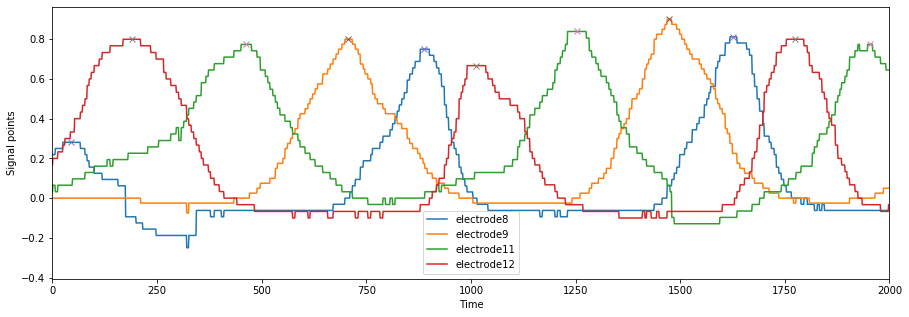

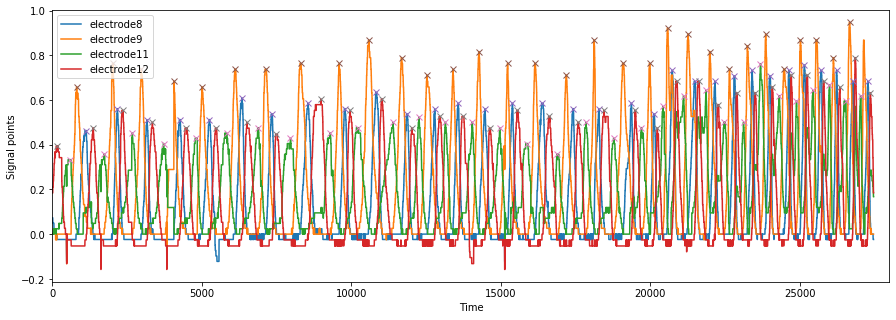

In [14]:
print(os.getcwd())
os.chdir('D:\\signal_etee_trackpad')
print(os.getcwd())

data1 = get_electrode_data('circle5.csv')
# data = np.clip(data,0,804)
peaks = find_peak(data1,height=0.2,distance = 500)
plot_electrode_data(data1)
plot_peaks(data1,peaks)
plt.xlim([0,2000])

elec_sequence = electrode_sequence(anticlock_sequence)
final_peak,angle_seq = arrage_peaks_seq(peaks,elec_sequence)
print('angle_seq',angle_seq)
X1,y1  = create_training_data(data1,final_peak,angle_seq)
print(X1)

data2 = get_electrode_data('circle4.csv')
# data = np.clip(data,0,804)
peaks = find_peak(data2,height=0.2,distance = 500)
plot_electrode_data(data2)
plot_peaks(data2,peaks)
plt.xlim([0,28000])

elec_sequence = electrode_sequence(anticlock_sequence)
final_peak,angle_seq = arrage_peaks_seq(peaks,elec_sequence)
X2,y2  = create_training_data(data2,final_peak,angle_seq)
print(X2,y2)


### Training datasets  from Kiera's left thumb

D:\signal_etee_trackpad
D:\signal_etee_trackpad
number of peaks in electrode  8  =  34
number of peaks in electrode  9  =  35
number of peaks in electrode  11  =  35
number of peaks in electrode  12  =  34
[12, 11, 9, 8] 9
[11, 9, 8, 12] 9
[9, 8, 12, 11] 9
anticlockwise


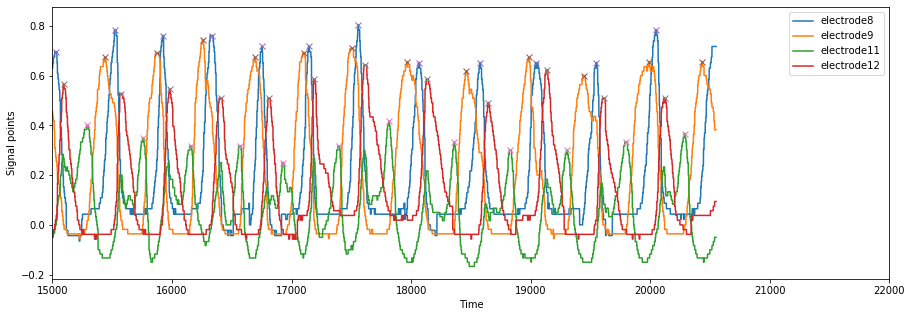

In [6]:
print(os.getcwd())
os.chdir('D:\\signal_etee_trackpad')
print(os.getcwd())

data3 = get_electrode_data('circle6.csv')
# data = np.clip(data,0,804)
peaks = find_peak(data3,height=0.2,distance = 350)
peaks[11] = peaks[11][1:]
plot_electrode_data(data3)
plot_peaks(data3,peaks)
plt.xlim([15000,22000])

elec_sequence = electrode_sequence(anticlock_sequence)
final_peak,angle_seq = arrage_peaks_seq(peaks,elec_sequence)
X3,y3  = create_training_data(data3,final_peak,angle_seq)

### Training datasets  from Mick's left thumb

D:\signal_etee_trackpad
D:\signal_etee_trackpad
number of peaks in electrode  8  =  113
number of peaks in electrode  9  =  114
number of peaks in electrode  11  =  114
number of peaks in electrode  12  =  114
[12, 11, 9, 8] 12
anticlockwise


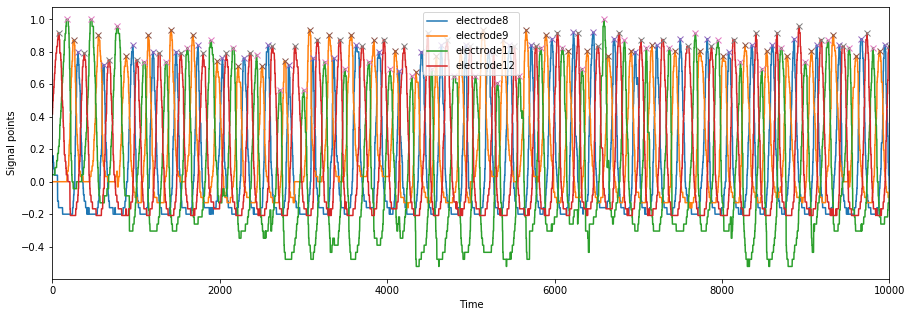

In [7]:
print(os.getcwd())
os.chdir('D:\\signal_etee_trackpad')
print(os.getcwd())

data4 = get_electrode_data('circle7.csv')
# data = np.clip(data,0,804)
peaks = find_peak(data4,height=0.2,distance = 200)
plot_electrode_data(data4)
plot_peaks(data4,peaks)
plt.xlim([0000,10000])

elec_sequence = electrode_sequence(anticlock_sequence)
final_peak,angle_seq = arrage_peaks_seq(peaks,elec_sequence)
X4,y4  = create_training_data(data4,final_peak,angle_seq)

### Training datasets  from Kuba's left thumb

D:\signal_etee_trackpad
D:\signal_etee_trackpad
number of peaks in electrode  8  =  238
number of peaks in electrode  9  =  238
number of peaks in electrode  11  =  239
number of peaks in electrode  12  =  238
[12, 11, 9, 8] 11
[11, 9, 8, 12] 11
anticlockwise


C:\Users\TG0\Anaconda3\lib\site-packages\IPython\core\events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\TG0\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


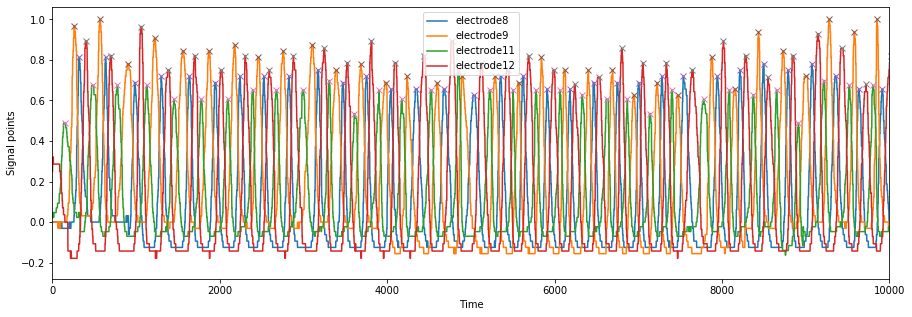

In [8]:
print(os.getcwd())
os.chdir('D:\\signal_etee_trackpad')
print(os.getcwd())

data5 = get_electrode_data('circle8.csv')
# data = np.clip(data,0,804)
peaks = find_peak(data5,height=0.4,distance = 150)
plot_electrode_data(data5)
plot_peaks(data5,peaks)
plt.xlim([0000,10000])

elec_sequence = electrode_sequence(anticlock_sequence)
final_peak,angle_seq = arrage_peaks_seq(peaks,elec_sequence)
X5,y5  = create_training_data(data5,final_peak,angle_seq)

### Training datasets  from Andy's left thumb

D:\signal_etee_trackpad
D:\signal_etee_trackpad
number of peaks in electrode  8  =  11
number of peaks in electrode  9  =  11
number of peaks in electrode  11  =  11
number of peaks in electrode  12  =  11
[12, 11, 9, 8] 12
anticlockwise


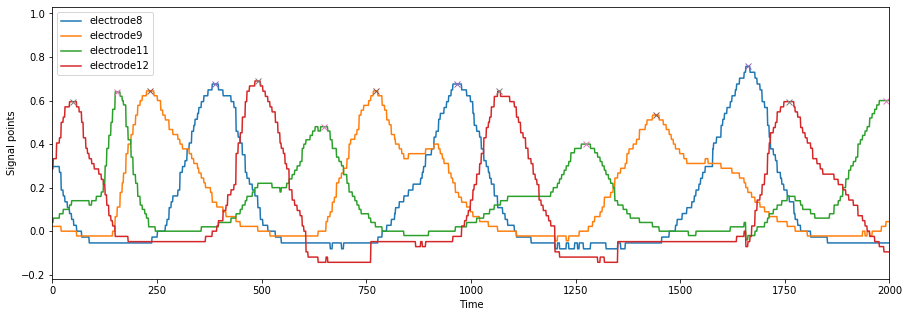

In [21]:
print(os.getcwd())
os.chdir('D:\\signal_etee_trackpad')
print(os.getcwd())

data6 = get_electrode_data('circle9.csv')
# data = np.clip(data,0,804)
peaks = find_peak(data6,height=0.3,distance = 400)
plot_electrode_data(data6)
plot_peaks(data6,peaks)
plt.xlim([0000,2000])

elec_sequence = electrode_sequence(anticlock_sequence)
final_peak,angle_seq = arrage_peaks_seq(peaks,elec_sequence)
X6,y6  = create_training_data(data6,final_peak,angle_seq)

### Training datasets  from Ying's left thumb, clockwise

D:\signal_etee_trackpad
D:\signal_etee_trackpad
number of peaks in electrode  8  =  51
number of peaks in electrode  9  =  50
number of peaks in electrode  11  =  50
number of peaks in electrode  12  =  51
[8, 9, 11, 12] 12
[9, 11, 12, 8] 12
[11, 12, 8, 9] 12
[12, 8, 9, 11] 12
[0.3, 5.0123889803846895, 3.441592653589793, 1.8707963267948966]
clockwise
number of peaks in electrode  8  =  42
number of peaks in electrode  9  =  42
number of peaks in electrode  11  =  41
number of peaks in electrode  12  =  41
[8, 9, 11, 12] 8
[5.0123889803846895, 3.441592653589793, 1.8707963267948966, 0.3]
clockwise


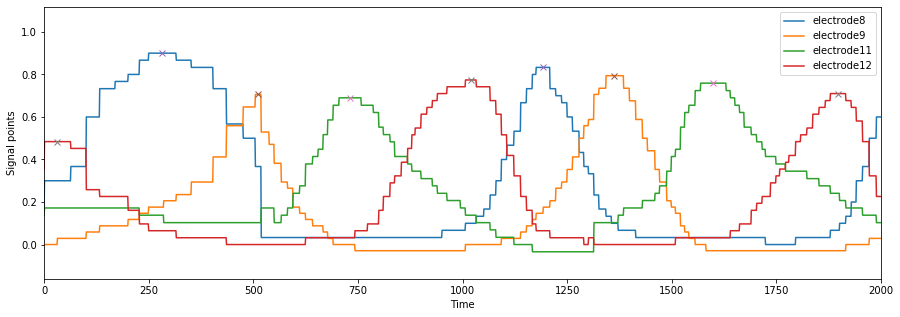

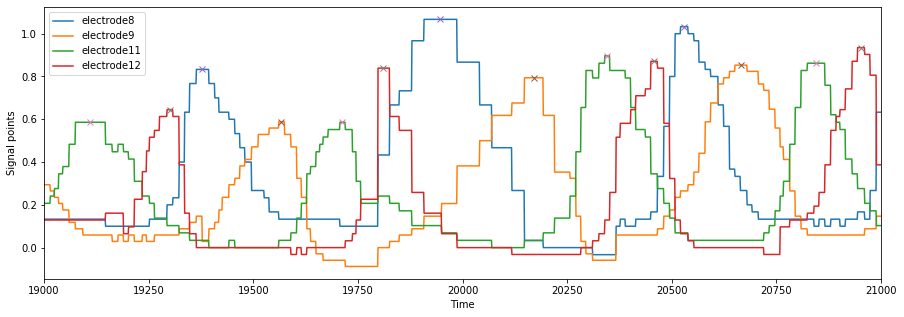

In [16]:
print(os.getcwd())
os.chdir('D:\\signal_etee_trackpad')
print(os.getcwd())

data7 = get_electrode_data('circle_clockwise_1.csv')
# data = np.clip(data,0,804)
peaks = find_peak(data7,height=0.3,distance = 400)
plot_electrode_data(data7)
plot_peaks(data7,peaks)
plt.xlim([0000,2000])

elec_sequence = electrode_sequence(clockwise_sequence)
final_peak,angle_seq = arrage_peaks_seq(peaks,elec_sequence)
print(angle_seq)
X7,y7  = create_training_data(data7,final_peak,angle_seq)

data8 = get_electrode_data('circle_clockwise_2.csv')[:29500]
# data = np.clip(data,0,804)
peaks = find_peak(data8,height=0.4,distance = 400)
plot_electrode_data(data8)
plot_peaks(data8,peaks)
plt.xlim([19000,21000])

elec_sequence = electrode_sequence(clockwise_sequence)
final_peak,angle_seq = arrage_peaks_seq(peaks,elec_sequence)
print(angle_seq)
X8,y8  = create_training_data(data8,final_peak,angle_seq)

### Training datasets  from Mick's left thumb, clockwise

D:\signal_etee_trackpad
D:\signal_etee_trackpad
number of peaks in electrode  8  =  93
number of peaks in electrode  9  =  93
number of peaks in electrode  11  =  94
number of peaks in electrode  12  =  93
[8, 9, 11, 12] 11
[9, 11, 12, 8] 11
[11, 12, 8, 9] 11
[1.8707963267948966, 0.3, 5.0123889803846895, 3.441592653589793]
clockwise
[[ 3.80000000e-02  8.70000000e-02  4.91000000e-01  7.50000000e-02
  -7.16502367e-01 -2.21640155e-01]
 [ 4.96000000e-02  8.48000000e-02  4.54200000e-01  1.26000000e-01
  -7.42353193e-01 -1.06825732e-01]
 [ 6.12000000e-02  8.26000000e-02  4.17400000e-01  1.77000000e-01
  -7.49924819e-01  1.06190942e-02]
 ...
 [ 3.80000000e-03  2.56200000e-01  4.62800000e-01  8.66000000e-02
  -6.12943670e-01 -4.32203722e-01]
 [ 1.90000000e-03  1.93100000e-01  5.11900000e-01  9.98000000e-02
  -6.73008875e-01 -3.30997061e-01]
 [-1.30104261e-18  1.30000000e-01  5.61000000e-01  1.13000000e-01
  -7.16502367e-01 -2.21640155e-01]]


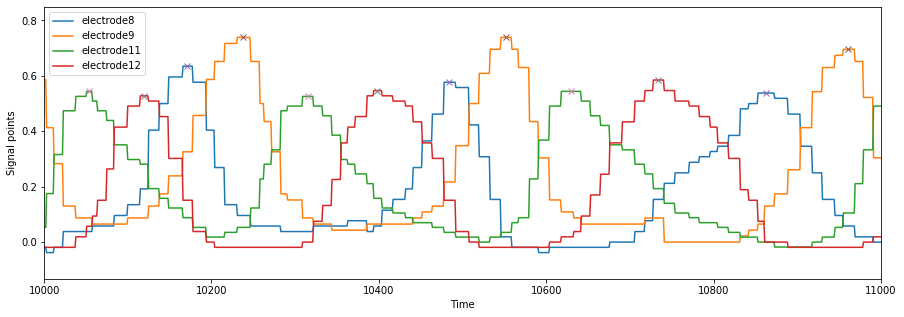

In [19]:
print(os.getcwd())
os.chdir('D:\\signal_etee_trackpad')
print(os.getcwd())

data9 = get_electrode_data('circle_clockwise_3.csv')
# data = np.clip(data,0,804)
peaks = find_peak(data9,height=0.2,distance = 200)
plot_electrode_data(data9)
plot_peaks(data9,peaks)
plt.xlim([10000,11000])

elec_sequence = electrode_sequence(clockwise_sequence)
final_peak,angle_seq = arrage_peaks_seq(peaks,elec_sequence)
print(angle_seq)
X9,y9  = create_training_data(data9,final_peak,angle_seq)
print(np.hstack((X9,y9)))

### Training datasets from Ying's left thumb,  boundary

In [ ]:
print(os.getcwd())
os.chdir('D:\\signal_etee_trackpad')
print(os.getcwd())

data10 = get_electrode_data('circle_boundary_1.csv')
# data = np.clip(data,0,804)
peaks = find_peak(data10,height=0.13,distance = 220)
plot_electrode_data(data10)
plot_peaks(data10,peaks)
plt.xlim([000,5000])

elec_sequence = electrode_sequence(anticlock_sequence)
final_peak,angle_seq = arrage_peaks_seq(peaks,elec_sequence)
print(angle_seq)
X10,y10  = create_training_data(data10,final_peak,angle_seq,boundary=1)

data11 = get_electrode_data('circle_boundary_2.csv')
# data = np.clip(data,0,804)
peaks = find_peak(data11,height=0.13,distance = 230)
plot_electrode_data(data11)
plot_peaks(data11,peaks)
plt.xlim([10000,15000])

elec_sequence = electrode_sequence(clockwise_sequence)
final_peak,angle_seq = arrage_peaks_seq(peaks,elec_sequence)
print(angle_seq)
X11,y11  = create_training_data(data11,final_peak,angle_seq,boundary=1)


data12 = get_electrode_data('circle_boundary_3.csv')
# data = np.clip(data,0,804)
peaks = find_peak(data12,height=0.13,distance = 230)
plot_electrode_data(data12)
plot_peaks(data12,peaks)
plt.xlim([10000,15000])

elec_sequence = electrode_sequence(anticlock_sequence)
final_peak,angle_seq = arrage_peaks_seq(peaks,elec_sequence)
print(angle_seq)
X12,y12  = create_training_data(data12,final_peak,angle_seq,boundary=1)

data13 = get_electrode_data('circle_boundary_clockwise_4.csv')
# data = np.clip(data,0,804)
peaks = find_peak(data13,height=0.11,distance = 180)
plot_electrode_data(data13)
plot_peaks(data13,peaks)
plt.xlim([0000,10000])

elec_sequence = electrode_sequence(clockwise_sequence)
final_peak,angle_seq = arrage_peaks_seq(peaks,elec_sequence)
print(angle_seq)
X13,y13  = create_training_data(data13,final_peak,angle_seq,boundary=1)

data14 = get_electrode_data('circle_boundary_anticlock_5.csv')
# data = np.clip(data,0,804)
peaks = find_peak(data14,height=0.11,distance = 150)
plot_electrode_data(data14)
plot_peaks(data14,peaks)
# plt.xlim([0000,15000])

elec_sequence = electrode_sequence(anticlock_sequence)
final_peak,angle_seq = arrage_peaks_seq(peaks,elec_sequence)
print(angle_seq)
X14,y14  = create_training_data(data14,final_peak,angle_seq,boundary=1)

In [ ]:

def plotacc(history,j):
    y = history.history['acc']
    x = range(1,len(y)+1)
    plt.plot(x,y,label=str(j) + ' datasets training ')
    
    return y[-1]
    
def plotval_loss(history):
    y = history.history['val_loss']
    x = range(1,len(y)+1)
    plt.plot(x,y)
    plt.xlabel("Epoch")
    plt.ylabel("Validation Error")
    print('Minimum MSE: ', min(y))
    return y[-1]

def acc_eval(y_true, y_pred):
    for y in [y_true,y_pred]:
        if type(y) == pd.DataFrame:
            y = y.to_numpy()
    return np.average(np.sum(y_true - y_pred,axis=0))

### Distinguish inner circle and outer circle
inner is 1 - 9
outer is 10 - 14

In [ ]:
print(y1)


In [ ]:
dataset_num = 14
for i in range(1,10):
    y = inner_outer_circle_training_data(eval('X'+str(i)),label=0)
    if i == 1:
        y_data = y
    else:
        y_data = np.vstack((y_data,y))
for i in range(10,dataset_num+1):
    y = inner_outer_circle_training_data(eval('X'+str(i)),label=1)
    y_data = np.vstack((y_data,y))

X_data = np.vstack((eval('X'+str(i)) for i in range(1,dataset_num + 1)))

### Train a model to distinguish inner circle and outer circle
1. distinguish and save model
2. train trackpad outer circle coordinates model
3. train trackpad intensity model

In [ ]:
print(os.getcwd())
os.chdir(r'D:/python_projects/etee_server/etee_driver/models/')
print(os.getcwd())

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.33, random_state=2018)
print(len(X_train))


circle_loc = KNeighborsClassifier(n_neighbors=5)
circle_loc.fit(X_train,y_train)
y_pred = circle_loc.predict(X_test)
print(sum(abs(y_test-y_pred.reshape(-1,1)))/len(y_test))
with open('etee_trackpad_circle_classifier.pkl', 'wb') as fid:
    pickle.dump(circle_loc, fid)


circle_loc = Sequential()
circle_loc.add(Dense(units = 10,activation="linear", input_dim=4))
circle_loc.add(Dense(1, activation="linear"))
circle_loc.compile(optimizer='adam',loss = 'mean_squared_error',metrics=['accuracy'])
num_epochs = 100
batch_size = 128
circle_loc.fit(x = X_train,y = y_train, epochs=num_epochs, batch_size=batch_size, shuffle=True, validation_data=(X_train, y_train),verbose=1)
y_pred = circle_loc.predict(X_test)
print(sum(abs(y_test-y_pred.reshape(-1,1)))/len(y_test))
circle_loc.save('etee_trackpad_outercircle_intensity_model.h5')

# X_data = np.vstack((eval('X'+str(i)) for i in range(10,dataset_num + 1)))
# y_data = np.vstack((eval('y'+str(i)) for i in range(10,dataset_num + 1)))
# X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.33, random_state=2018)
# model = Sequential()
# model.add(Dense(units = 10,activation="linear", input_dim=4))
# model.add(Dense(8, activation="linear"))
# model.add(Dense(4, activation="relu"))
# model.add(Dense(2, activation="linear"))
# model.compile(optimizer='adam',loss = 'mean_squared_error',metrics=['accuracy'])
# num_epochs = 100
# batch_size = 128
# model.fit(x = X_train,y = y_train, epochs=num_epochs, batch_size=batch_size, shuffle=True, validation_data=(X_train, y_train),verbose=1)

# y_pred = model.predict(X_test,verbose=1)
# accuracy_score_MAE = mean_absolute_error(y_test, y_pred, multioutput='raw_values')
# accuracy = np.sqrt(accuracy_score_MAE[0]**2 + accuracy_score_MAE[1]**2)
# print(accuracy)
# model.save('etee_trackpad_outercircle_model.h5')

In [ ]:
# model.predict(np.array([[0.05,0.073,0.2,0.073]]))
# X_test

## Train a model for coordinates prediction

C:\Users\TG0\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  
C:\Users\TG0\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  import sys


(24717, 2) (24717, 4)
Train on 16560 samples, validate on 8157 samples
Epoch 1/200
16560/16560 [==============================] - 1s 46us/sample - loss: 0.3782 - accuracy: 0.3815 - val_loss: 0.2704 - val_accuracy: 0.5728
Epoch 2/200
16560/16560 [==============================] - 0s 12us/sample - loss: 0.2233 - accuracy: 0.6963 - val_loss: 0.1864 - val_accuracy: 0.7730
Epoch 3/200
16560/16560 [==============================] - 0s 12us/sample - loss: 0.1674 - accuracy: 0.7994 - val_loss: 0.1503 - val_accuracy: 0.8208
Epoch 4/200
16560/16560 [==============================] - 0s 13us/sample - loss: 0.1354 - accuracy: 0.8392 - val_loss: 0.1183 - val_accuracy: 0.8626
Epoch 5/200
16560/16560 [==============================] - 0s 12us/sample - loss: 0.0987 - accuracy: 0.8864 - val_loss: 0.0769 - val_accuracy: 0.9153
Epoch 6/200
16560/16560 [==============================] - 0s 12us/sample - loss: 0.0571 - accuracy: 0.9383 - val_loss: 0.0393 - val_accuracy: 0.9615
Epoch 7/200
16560/16560 [====

Epoch 55/200
16560/16560 [==============================] - 0s 12us/sample - loss: 0.0154 - accuracy: 0.9761 - val_loss: 0.0154 - val_accuracy: 0.9733
Epoch 56/200
16560/16560 [==============================] - 0s 12us/sample - loss: 0.0154 - accuracy: 0.9760 - val_loss: 0.0154 - val_accuracy: 0.9735
Epoch 57/200
16560/16560 [==============================] - 0s 12us/sample - loss: 0.0154 - accuracy: 0.9763 - val_loss: 0.0154 - val_accuracy: 0.9743
Epoch 58/200
16560/16560 [==============================] - 0s 12us/sample - loss: 0.0154 - accuracy: 0.9760 - val_loss: 0.0154 - val_accuracy: 0.9743
Epoch 59/200
16560/16560 [==============================] - 0s 12us/sample - loss: 0.0154 - accuracy: 0.9767 - val_loss: 0.0154 - val_accuracy: 0.9751
Epoch 60/200
16560/16560 [==============================] - 0s 12us/sample - loss: 0.0154 - accuracy: 0.9759 - val_loss: 0.0154 - val_accuracy: 0.9750
Epoch 61/200
16560/16560 [==============================] - 0s 12us/sample - loss: 0.0154 - ac

16560/16560 [==============================] - 0s 12us/sample - loss: 0.0154 - accuracy: 0.9763 - val_loss: 0.0154 - val_accuracy: 0.9732
Epoch 110/200
16560/16560 [==============================] - 0s 13us/sample - loss: 0.0154 - accuracy: 0.9763 - val_loss: 0.0154 - val_accuracy: 0.9754
Epoch 111/200
16560/16560 [==============================] - 0s 13us/sample - loss: 0.0154 - accuracy: 0.9766 - val_loss: 0.0154 - val_accuracy: 0.9750
Epoch 112/200
16560/16560 [==============================] - 0s 13us/sample - loss: 0.0154 - accuracy: 0.9762 - val_loss: 0.0154 - val_accuracy: 0.9740
Epoch 113/200
16560/16560 [==============================] - 0s 12us/sample - loss: 0.0154 - accuracy: 0.9763 - val_loss: 0.0155 - val_accuracy: 0.9738
Epoch 114/200
16560/16560 [==============================] - 0s 12us/sample - loss: 0.0154 - accuracy: 0.9768 - val_loss: 0.0155 - val_accuracy: 0.9754
Epoch 115/200
16560/16560 [==============================] - 0s 13us/sample - loss: 0.0154 - accuracy:

Epoch 163/200
16560/16560 [==============================] - 0s 12us/sample - loss: 0.0154 - accuracy: 0.9758 - val_loss: 0.0154 - val_accuracy: 0.9755
Epoch 164/200
16560/16560 [==============================] - 0s 13us/sample - loss: 0.0154 - accuracy: 0.9762 - val_loss: 0.0155 - val_accuracy: 0.9739
Epoch 165/200
16560/16560 [==============================] - 0s 12us/sample - loss: 0.0154 - accuracy: 0.9761 - val_loss: 0.0154 - val_accuracy: 0.9752
Epoch 166/200
16560/16560 [==============================] - 0s 12us/sample - loss: 0.0154 - accuracy: 0.9763 - val_loss: 0.0154 - val_accuracy: 0.9747
Epoch 167/200
16560/16560 [==============================] - 0s 12us/sample - loss: 0.0154 - accuracy: 0.9757 - val_loss: 0.0154 - val_accuracy: 0.9754
Epoch 168/200
16560/16560 [==============================] - 0s 13us/sample - loss: 0.0154 - accuracy: 0.9759 - val_loss: 0.0154 - val_accuracy: 0.9736
Epoch 169/200
16560/16560 [==============================] - 0s 12us/sample - loss: 0.01

0.13960333166507352


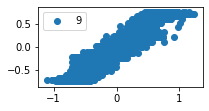

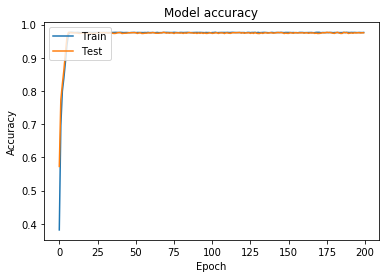

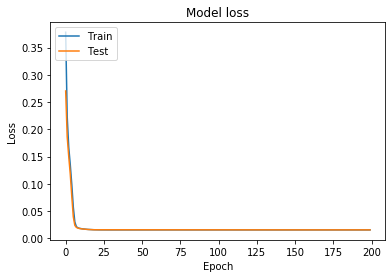

In [12]:
plt.figure(figsize=(10,5))
scaler = MinMaxScaler()
# scaler.fit_transform(X_data)
for j in range(9,10):
    dataset_num = j
    X_data = np.vstack(( scaler.fit_transform(eval('X'+str(i))) for i in [2,3,4,5,6,8,9]))
    y_data = np.vstack((eval('y'+str(i)) for i in [2,3,4,5,6,8,9]))
#     X_data = scaler.fit_transform(eval('X'+str(j)))
#     X_data = eval('X'+str(j))
#     y_data = eval('y'+str(j))
# #     X_data = np.vstack((X2,X3,X4,X5,X9))
#     X_data = scaler.fit_transform(X_data)
#     y_data = np.vstack((y2,y3,y4,y5,y9))
    X_data = np.where(X_data > 0, X_data * 1.1, X_data)
    print(y_data.shape,X_data.shape)
#     scaler = MinMaxScaler()
#     scaler.fit_transform(X_data)

    np.savetxt(r'D:\\signal_etee_trackpad\training_data.csv',np.hstack((X_data,y_data)),delimiter=",",fmt='%.3f')
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.33, random_state=2018)

    model = Sequential()
    model.add(Dense(units = 6,activation="linear", input_dim=4))
#     model.add(Dense(16, activation="relu"))
#     model.add(Dense(32, activation="relu"))
#     model.add(Dense(64, activation="relu"))
    model.add(Dense(2, activation="linear"))
    model.compile(optimizer='adam',loss = 'mean_squared_error',metrics=['accuracy'])
    
    num_epochs = 200
    batch_size = 128
    history = model.fit(x = X_train,y = y_train, epochs=num_epochs, batch_size=batch_size, 
                        shuffle=True, validation_data=(X_test, y_test),verbose=1)
    
    y_pred = model.predict(X_test,verbose=1)
    plt.subplot(3,3,j)
    plt.scatter(y_pred[:,0],y_test[:,0],label=str(j))
    plt.legend()
    accuracy_score_MAE = mean_absolute_error(y_test, y_pred, multioutput='raw_values')
    accuracy = np.sqrt(accuracy_score_MAE[0]**2 + accuracy_score_MAE[1]**2)
    print(accuracy)
#     plt.plot(j*10, 1 - accuracy,'x',label='accuracy with ' + str(j) + ' datasets')
    
# plt.xlabel("Epoch")
# plt.ylabel("Validation accuracy")
# plt.legend()
# plt.ylim([0.8,1])
# print(os.getcwd())
# os.chdir(r'D:/python_projects/etee_server/etee_driver/models/')
# print(os.getcwd())
# plt.show()
# print(history.history.keys())

# Plot training & validation accuracy values
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


# model.save('etee_trackpad_model.h5')
# with open('etee_trackpad_scaler.pkl', 'wb') as fid:
#     pickle.dump(scaler, fid)


# Check the distribution of prediction and actual result and previous published one with only matrix

Text(0.5, 1.0, 'prediction from previous matrix')

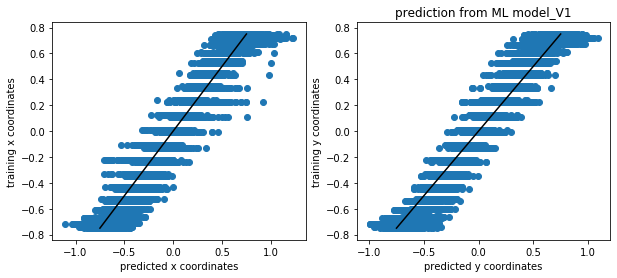

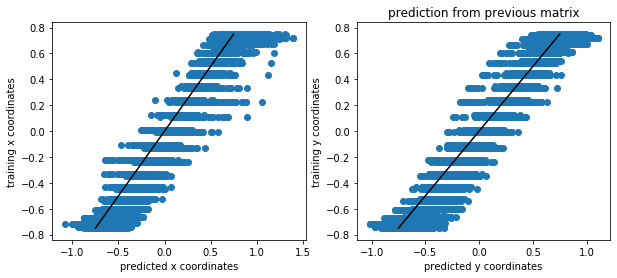

In [13]:
h5_model = model
h5_model.save('D:/python_projects/etee_server/etee_driver/models/etee_trackpad_model_V1.h5')
weight = np.array([[ 1.22641896,  0.45281722],[ 0.59463960, -0.96124816],[-0.75184826, -0.24490311], [-0.05682517,  1.02013802]])
bias = np.array([-0.24198828,  0.0240661])
matrix_pred = X_test@weight + bias
# print(X_test@weight)
# print(matrix_pred)

plt.figure(figsize = [10,4])
plt.subplot(1,2,1)
plt.scatter(y_pred[:,0],y_test[:,0])
plt.plot(np.linspace(-0.75,0.75,100),np.linspace(-0.75,0.75,100),'k-')
plt.xlabel('predicted x coordinates')
plt.ylabel('training x coordinates')
plt.subplot(1,2,2)
plt.scatter(y_pred[:,1],y_test[:,1])
plt.plot(np.linspace(-0.75,0.75,100),np.linspace(-0.75,0.75,100),'k-')
plt.xlabel('predicted y coordinates')
plt.ylabel('training y coordinates')
plt.title('prediction from ML model_V1')

plt.figure(figsize = [10,4])
plt.subplot(1,2,1)
plt.scatter(matrix_pred[:,0],y_test[:,0])
plt.plot(np.linspace(-0.75,0.75,100),np.linspace(-0.75,0.75,100),'k-')
plt.xlabel('predicted x coordinates')
plt.ylabel('training x coordinates')
plt.subplot(1,2,2)
plt.scatter(matrix_pred[:,1],y_test[:,1])
plt.plot(np.linspace(-0.75,0.75,100),np.linspace(-0.75,0.75,100),'k-')
plt.xlabel('predicted y coordinates')
plt.ylabel('training y coordinates')
plt.title('prediction from previous matrix')

## convert to tensorflow lite for c++ audrino

In [ ]:
h5_model = load_model("D:/python_projects/etee_server/etee_driver/models/etee_trackpad_model_V1.h5")
converter = tf.lite.TFLiteConverter.from_keras_model(h5_model)
tflite_model = converter.convert()

# Save the model to disk
open("D:/python_projects/etee_server/etee_driver/models/etee_trackpad_model.tflite", "wb").write(tflite_model)

# Convert the model to the TensorFlow Lite format with quantization
converter = tf.lite.TFLiteConverter.from_keras_model(h5_model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

# Save the model to disk
open("etee_trackpad_model_quantized.tflite", "wb").write(tflite_model)

# Load prediction data from existing model

In [ ]:
df = pd.read_csv(r'D:\\signal_etee_trackpad\predicted_data.csv')
print(df.columns)
X_test = df[['7','8','10','11']]
y_test = df[['test_coord_x','test_coord_y']]
y_pred = df[['pred_coord_x','pred_coord_y']]

## Test .h5 model and .tflite model prediction result
###   .tflite model file result

In [ ]:
# plt.scatter(y_pred[:,0],y_test[:,0])
# plt.xlabel('predicted x coordinates')
# plt.ylabel('training x coordinates')

# for i,pred in enumerate(y_pred[:,1]):
#     if abs(y_test[i,1]-pred)>1:
#         print(y_test[i])
# model.save('etee_trackpad_model.h5')    
# os.chdir(r'D:/python_projects/etee_server/etee_driver/models/')
# from tensorflow.keras.models import load_model
# model = load_model('etee_trackpad_model.tflite')
# model.predict(np.array([[0.152,0.180,0.359,0.532]]))
# np.savetxt(r'D:\\signal_etee_trackpad\predicted_data.csv',np.hstack((X_test,y_test,y_pred)),delimiter=",",header = 'electrode 7,8,10,11, test_coord_x, test_coord_y, pred_coord_x, pred_coord_y',fmt='%.4f')
# #0.717,0.222


# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="D:/python_projects/etee_server/etee_driver/models/etee_trackpad_model_quantized.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# # Test model on random input data.
input_shape = input_details[0]['shape']
input_data = np.array([[0.08360000,0.82030000,0.10000000,0.03050000]], dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)
print(input_data)


interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

### .h5 result

In [ ]:

h5_model = load_model("D:/python_projects/etee_server/etee_driver/models/etee_trackpad_model.h5")
input_data = np.array([[0.08360000,0.82030000,0.10000000,0.03050000]], dtype=np.float32)
output_data = h5_model.predict(input_data)
print(output_data)

In [ ]:
model.predict(np.array([[0.219,0.800,-0.129,-0.067]]))

In [ ]:
config =[]
weight = []
for layer in model.layers:
    config.append(layer.get_config())
    weight.append(layer.get_weights())
print(weight)
# print(config)

print(os.getcwd())
os.chdir(r'D:/python_projects/etee_server/etee_driver/models/')
print(os.getcwd())

params = []
for i in range(4):
    matrix = np.zeros((4))
    matrix[i] = 1
    param11=(matrix@weight[0][0]+weight[0][1])@weight[1][0]+weight[1][1]
    matrix[i] = 2
    param12=(matrix@weight[0][0]+weight[0][1])@weight[1][0]+weight[1][1]
    print(param12 - param11)

matrix = np.zeros((4))
param13=(matrix@weight[0][0]+weight[0][1])@weight[1][0]+weight[1][1]
params.append(param13)

print('model',params)

# model.save('etee_trackpad_model.h5')
# with open('etee_trackpad_model_matrix_simple.txt', 'w') as f:
#     for item in weight:
#         f.write("%s\n" % item)

### Create training data for outer circle

In [ ]:
dataset_num = 14
X_data = np.vstack((eval('X'+str(i)) for i in range(1,dataset_num + 1)))
y_data = np.vstack((eval('y'+str(i)) for i in range(1,dataset_num + 1)))
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.33, random_state=2018)
model = Sequential()
model.add(Dense(units = 10,activation="linear", input_dim=4))
model.add(Dense(8, activation="linear"))
model.add(Dense(6, activation="relu"))
model.add(Dense(2, activation="linear"))
model.compile(optimizer='adam',loss = 'mean_squared_error',metrics=['accuracy'])

num_epochs = 100
batch_size = 128
model.fit(x = X_train,y = y_train, epochs=num_epochs, batch_size=batch_size, shuffle=True, validation_data=(X_train, y_train),verbose=1)
    
model.save('etee_trackpad_outercircle_model.h5')


In [ ]:
print(scaler.transform(np.array([[0.031, 0.023, 0.103, 0.094]])))
y_pred = model.predict(X_test,verbose=1)
accuracy_score_EVS = explained_variance_score(y_test, y_pred, multioutput='raw_values')
accuracy_score_MAE = mean_absolute_error(y_test, y_pred, multioutput='raw_values')
print('accuracy_score from variance       = ',accuracy_score_EVS,)
print('accuracy_score from absolute error = ',accuracy_score_MAE)

# Clockwise and Anti-clockwise predicition, 0 is anti and 1 is clockwise
## clip all data into time series

In [ ]:
anti_clock_datasets_num = 6
time_length = 100
def create_time_series(X):
    X_data = []
    X= X.to_numpy()
    for i in range(len(X)):
        
        x = X[i:i+time_length].T.flatten()
        if len(x) < time_length*4:
            return X_data
        X_data.append(X[i:i+time_length].T.flatten())
        
X1_data = np.vstack((create_time_series(eval('data'+str(i))) for i in range(1,anti_clock_datasets_num + 1)))

label1 = np.zeros((X1_data.shape[0],1))
X2_data = np.vstack((create_time_series(eval('data'+str(i))) for i in range(anti_clock_datasets_num + 1,dataset_num + 1)))
label2 = np.ones((X2_data.shape[0],1))
X_data = np.vstack((X1_data,X2_data))
y_data = np.vstack((label1,label2))
print('number of time series:',len(X_data))
print('Number of unique classes:', len(np.unique(y_data)))
print('Time series length: ',len(X_data[0,:]))

ran_example = random.randint(0, len(X_data)-1)
print('random example ',ran_example)
for i in range(4):
    plt.plot(np.linspace(0,time_length,time_length), X_data[ran_example, i*time_length : (i+1)* time_length],label = y_data[ran_example])
plt.legend()

### Training using NN

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.33, random_state=2018)

num_epochs = 50
batch_size = 128
circle_model = Sequential()
circle_model.add(Dense(units = 10,activation="linear", input_dim=time_length * len(pair)))
circle_model.add(Dense(8, activation="relu"))
circle_model.add(Dense(8, activation="relu"))
circle_model.add(Dense(1, activation="relu"))
circle_model.compile(optimizer='adam',loss = 'mean_squared_error',metrics=['accuracy'])
circle_model.fit(x = X_train,y = y_train, epochs=num_epochs, batch_size=batch_size, shuffle=True, validation_data=(X_train, y_train),verbose=1)

pred = circle_model.predict(X_test)

# ks = KShape(n_clusters = 2,max_iter = 100,n_init = 200,verbose = 1)
# ks.fit(X_train)
# pred = ks.predict(X_test)
accuracy = np.sum(np.abs(np.abs(pred - y_test)))/len(X_test)
print('accuracy',accuracy)
os.chdir(r'D:\\Python_projects/etee_server/etee_driver/models/')
print(os.getcwd())
circle_model.save('circle_direction_model_nn.h5')

### Training using K-shape

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.33, random_state=2018)



ks = KShape(n_clusters = 2,max_iter = 10,n_init = 10,verbose = 1)
ks.fit(X_train)
pred = ks.predict(X_test)
print(np.hstack(pred,ytrain))
accuracy = np.sum(np.abs(np.abs(pred - y_test)))/len(X_test)
print(accuracy)
os.chdir(r'D:\\Python_projects/etee_server/etee_driver/models/')
print(os.getcwd())
ks.save('circle_direction_model_ks.h5')

# swipe direction predicition, 0 is up, 1 is left, 2 is down, 3 is right
## clip all data into time series

In [ ]:
swipe_time_length = 100
def sort_swipe_data(data,direction,boundary = 0.05):
    dataset = []
    dataset_temp = []
    i = 0
    for row in data:
        if all(j < boundary for j in row):
            if len(dataset_temp) == 0:
                continue
            elif all(m < (boundary + 0.1) for m in np.array(dataset_temp).T.flatten()):
                dataset_temp = []
            elif len(dataset_temp) < swipe_time_length:
                while len(dataset_temp) < swipe_time_length:
                    dataset_temp.append([0]*len(pair))
            elif len(dataset_temp) >= swipe_time_length: 
                print(len(dataset_temp))
                dataset.append(np.array(dataset_temp[-swipe_time_length:]).T.flatten())
                dataset_temp = []
        else:
            dataset_temp.append(row)
    print('>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Next')
    dataset = np.array(dataset)
    if direction == 'up': 
        direction = 0
    elif direction == 'left': 
        direction = 1
    elif direction == 'down':
        direction = 2
    elif direction == 'right':
        direction = 3
    else:
        print('error argument in direction')
    label = np.ones((len(dataset),1)) * direction
    dataset = np.hstack((dataset,label))
    return np.array(dataset)
    

### Swipe signal shape


In [ ]:
def plot_swipe_signal(direction):
    data = np.genfromtxt('swipe_'+ direction +'.csv',delimiter=',')[1:]
    plt.figure(figsize=(20,5))
    time = np.linspace(0, len(data)-1, len(data))
    for i,pair_elec in enumerate(pair):
        plt.plot(time, data[:,i],label=str(pair_elec))
    return data
    
plot_swipe_signal('up_1')
plot_swipe_signal('down_1')
plot_swipe_signal('left_1')
plot_swipe_signal('right_1')

In [ ]:
print(os.getcwd())
os.chdir('D:\\signal_etee_trackpad')
print(os.getcwd())

data_up = plot_swipe_signal('up_1')
X1 = sort_swipe_data(data_up,'up',boundary = 0.2)

y1 = X1[:,-1]
X1 = X1[:,:-1]

data_down = plot_swipe_signal('down_1')
X2 = sort_swipe_data(data_down,'down',boundary = 0.08)
y2 = X2[:,-1]
X2 = X2[:,:-1]


data_left = plot_swipe_signal('left_1')
X3 = sort_swipe_data(data_left,'left',boundary = 0.2)
y3 = X3[:,-1]
X3 = X3[:,:-1]


data_right = plot_swipe_signal('right_1')[500:]
X4 = sort_swipe_data(data_right,'right',boundary = 0.2)
y4 = X4[:,-1]
X4 = X4[:,:-1]

data_up = plot_swipe_signal('up_2')
X5 = sort_swipe_data(data_up,'up',boundary = 0.2)

y5 = X5[:,-1]
X5 = X5[:,:-1]

data_down = plot_swipe_signal('down_2')
X6 = sort_swipe_data(data_down,'down',boundary = 0.08)
y6 = X6[:,-1]
X6 = X6[:,:-1]


data_left = plot_swipe_signal('left_2')
X7 = sort_swipe_data(data_left,'left',boundary = 0.2)
y7 = X7[:,-1]
X7 = X7[:,:-1]


data_right = plot_swipe_signal('right_2')
X8 = sort_swipe_data(data_right,'right',boundary = 0.1)
y8 = X8[:,-1]
X8 = X8[:,:-1]

print(X1.shape,'\n',X2.shape,'\n',X3.shape,'\n',X4.shape,'\n')
print(y1.shape,'\n',y2.shape,'\n',y3.shape,'\n',y4.shape,'\n')

num_data = 8
X_data = np.vstack([eval('X'+str(i)) for i in range(1,num_data+1)])
y_data = np.hstack([eval('y'+str(i)) for i in range(1,num_data+1)]).T

# np.savetxt(r'D:\\signal_etee_trackpad\swipe_training_data.csv',np.hstack((X_data,y_data)),delimiter=",")

ran_example = random.randint(0, len(X_data)-1)
for i in range(4):
    plt.plot(np.linspace(0,time_length,time_length), X_data[ran_example, i*time_length : (i+1)* time_length],label = y_data[ran_example])
plt.legend()

### Choose a random sample and observe

In [ ]:
ran_example = random.randint(0, len(X_data)-1)
for i in range(4):
    plt.plot(np.linspace(0,time_length,time_length), X_data[ran_example, i*time_length : (i+1)* time_length],label = y_data[ran_example])
plt.legend()

### Swipe training using NN

In [ ]:
num_epochs = 3000
# batch_size = 128
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.33, random_state=2018)
swipe_model = Sequential()
swipe_model.add(Dense(units = 10,activation="linear", input_dim=swipe_time_length * len(pair) ))
swipe_model.add(Dense(10, activation="relu"))
swipe_model.add(Dense(5, activation="linear"))
swipe_model.add(Dense(1, activation="linear"))
swipe_model.compile(optimizer='adam',loss = 'mean_squared_error',metrics=['accuracy'])
swipe_model.fit(x = X_train,y = y_train, epochs=num_epochs, batch_size=batch_size, shuffle=True, validation_data=(X_train, y_train),verbose=1)



In [ ]:
pred =  swipe_model.predict(X_test)
print(pred.shape,y_test.shape)
print(np.vstack((pred[:,0],y_test)).T)
accuracy = np.sum(np.abs(pred - y_test))/len(X_test)
print('accuracy = ', accuracy)
os.chdir(r'D:\\Python_projects/etee_server/etee_driver/models/')
print(os.getcwd())
swipe_model.save('swipe_direction_model_nn.h5')

### Swipe training using Kshape

In [ ]:

max_iter = 200

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.33, random_state=2018)
ks = KShape(n_clusters = 4,max_iter = max_iter,n_init = 10,verbose = 1,random_state=2019)
ks.fit(X_train)


In [ ]:
pred = ks.predict(X_train)
print(pred.shape)
print(np.vstack((pred,y_train)).T)
# accuracy = np.sum(np.abs(np.abs(pred - y_train)))/len(X_test)
print(accuracy)
os.chdir(r'D:\\Python_projects/etee_server/etee_driver/models/')
print(os.getcwd())
# ks.save('swipe_direction_model_ks.h5')
import pickle
with open('swipe_direction_model_ks.pkl', 'wb') as fid:
    pickle.dump(ks, fid)  
pred = ks.predict([X_train[4]])
print(pred)


In [ ]:
### Accuracy evaluation
| Number of Label >>>>>prediction  vvv True Label | up | down | left | right |
|------------------------------------------------|----|------|------|-------|
| UP                                             |    |      |      |       |
| DOWN                                           |    |      |      |       |
| LEFT                                           |    |      |      |       |
| RIGHT                                          |    |      |      |       |